# **Data Import and Preprocessing**


In [29]:
import io
import pandas as pd

# Read the data correctly with a proper header
data = pd.read_csv(io.StringIO('''
Student_ID,Class Session,Pre Course Score,Exam 1,Exam 2,Exam 3,Exam 4,Exam 5,Exam 6,Exam 7,Exam 8,Actual Exam
1,1,NULL,1070,1110,1240,1230,1230,1190,1360,1360,1220
2,1,1110,1000,1270,1140,1140,1060,1260,1270,1350,1270
3,1,NULL,1260,1260,1330,1370,1360,1360,1360,1360,NULL
4,1,NULL,1300,1310,1310,1400,1400,1490,1460,1480,1300
5,1,NULL,1350,1360,1450,1450,1450,1510,1500,1530,1470
6,1,1100,1140,1130,1220,1200,1110,1270,1300,1310,1230
7,1,NULL,1080,1080,1050,1040,1080,1030,1100,1010,NULL
8,1,NULL,1410,1410,1410,1510,1490,1530,1520,1550,1480
9,1,NULL,1050,1050,1050,1050,1090,1090,1110,1110,NULL
10,2,NULL,1250,1240,1240,1240,1240,1240,1240,1240,NULL
11,2,NULL,1210,1230,1290,1270,1310,1300,1300,1340,1360
12,2,NULL,1090,1090,1210,1210,1180,1230,1180,1170,NULL
13,2,NULL,970,950,990,990,1010,1050,1020,1110,NULL
14,2,NULL,1130,1180,1260,1280,1240,1350,1280,1260,1250
15,2,950,1070,1020,1110,1070,970,1120,1070,1120,NULL
16,2,NULL,1160,1180,1190,1190,1270,1250,1270,1230,NULL
17,2,1280,1410,1460,1430,1430,1520,1520,1520,1480,1490
18,2,NULL,1030,1030,1240,1080,1130,1310,1260,1260,NULL
19,3,670,820,830,950,940,970,990,980,1080,NULL
20,3,1400,1300,1240,1440,1500,1510,1510,1550,1500,1400
21,3,NULL,1000,870,1000,940,940,1030,910,1010,NULL
22,3,NULL,1010,920,930,980,980,1060,1080,1090,NULL
23,3,NULL,1210,1220,1240,1240,1240,1290,1240,1360,NULL
24,3,NULL,980,980,980,1000,1050,1080,1130,1120,NULL
'''), header=0)

# Replace 'NULL' with NaN for numerical operations
data.replace("NULL", pd.NA, inplace=True)

# Convert all numeric columns (excluding Student_ID and Class Session)
numeric_columns = data.columns[2:]  # Exclude Student_ID and Class Session
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)

# **Using Gradient Boosting Descent to Fill Missing Values**

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Step 1: Prepare the data
# Select rows with all exam scores (1-8) and actual exam scores available
training_data = data.dropna(subset=['Actual Exam', 'Exam 1', 'Exam 2', 'Exam 3', 'Exam 4', 'Exam 5', 'Exam 6', 'Exam 7', 'Exam 8'])

# Features: Exam 1 through Exam 8
X_train = training_data[['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4', 'Exam 5', 'Exam 6', 'Exam 7', 'Exam 8']].values
y_train = training_data['Actual Exam'].values

# Step 2: Train the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

# Step 3: Predict missing Actual Exam scores
# Select rows where Actual Exam is missing but all Exam 1-8 scores are available
missing_actual_exam = data[data['Actual Exam'].isna() & data[['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4', 'Exam 5', 'Exam 6', 'Exam 7', 'Exam 8']].notna().all(axis=1)]

# Features: Exam 1 through Exam 8 for prediction
X_missing = missing_actual_exam[['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4', 'Exam 5', 'Exam 6', 'Exam 7', 'Exam 8']].values

# Predict Actual Exam scores
predicted_actual_exam = gbr_model.predict(X_missing)

# Step 4: Fill the missing Actual Exam scores with predictions
data.loc[missing_actual_exam.index, 'Actual Exam'] = predicted_actual_exam

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Step 1: Prepare the data
# Select rows where Pre Course Score and Exam 1 are available
pre_course_data = data.dropna(subset=['Pre Course Score', 'Exam 1'])

# Features: Exam 1 (predictor)
X_pre_course = pre_course_data[['Exam 1']].values
y_pre_course = pre_course_data['Pre Course Score'].values

# Step 2: Train the Gradient Boosting Regressor
gbr_model_pre_course = GradientBoostingRegressor()
gbr_model_pre_course.fit(X_pre_course, y_pre_course)

# Step 3: Predict missing Pre Course Scores
# Select rows where Pre Course Score is missing but Exam 1 is available
missing_pre_course = data[data['Pre Course Score'].isna() & data['Exam 1'].notna()]

# Features: Exam 1 for prediction
X_missing_pre_course = missing_pre_course[['Exam 1']].values

# Predict Pre Course Scores
predicted_pre_course = gbr_model_pre_course.predict(X_missing_pre_course)

# Step 4: Fill the missing Pre Course Scores with predictions
data.loc[missing_pre_course.index, 'Pre Course Score'] = predicted_pre_course

# **Do students who take the course show scores signifigantly higher than the benchmark averages?**

In [32]:
from scipy.stats import ttest_1samp
import numpy as np

# Averages
NJ_Average_SAT = 1066
US_Average_SAT = 1050
SouthBrunswick_Average_SAT = 1260

# Step 1: Filter Actual Exam Scores (including predicted values)
actual_exam_scores = data['Actual Exam'].dropna()  # Exclude NaN values

# Step 2: Perform one-sample t-tests
t_stat_nj, p_value_nj = ttest_1samp(actual_exam_scores, NJ_Average_SAT, alternative='greater')
t_stat_us, p_value_us = ttest_1samp(actual_exam_scores, US_Average_SAT, alternative='greater')
t_stat_ww, p_value_ww = ttest_1samp(actual_exam_scores, SouthBrunswick_Average_SAT, alternative='greater')

# Step 3: Print results
print("Comparison of Actual Exam Scores Against Averages:")
print(f"NJ Average SAT: Mean = {NJ_Average_SAT}")
print(f"  t-statistic = {t_stat_nj:.3f}, p-value = {p_value_nj:.3f}")
print(f"  Significant? {'Yes' if p_value_nj < 0.05 else 'No'}\n")

print(f"US Average SAT: Mean = {US_Average_SAT}")
print(f"  t-statistic = {t_stat_us:.3f}, p-value = {p_value_us:.3f}")
print(f"  Significant? {'Yes' if p_value_us < 0.05 else 'No'}\n")

print(f"South Brunswick Average SAT: Mean = {SouthBrunswick_Average_SAT}")
print(f"  t-statistic = {t_stat_ww:.3f}, p-value = {p_value_ww:.3f}")
print(f"  Significant? {'Yes' if p_value_ww < 0.05 else 'No'}")


Comparison of Actual Exam Scores Against Averages:
NJ Average SAT: Mean = 1066
  t-statistic = 13.407, p-value = 0.000
  Significant? Yes

US Average SAT: Mean = 1050
  t-statistic = 14.349, p-value = 0.000
  Significant? Yes

West Windsor Average SAT: Mean = 1260
  t-statistic = 1.991, p-value = 0.029
  Significant? Yes


# **Average Score Improvement**

In [33]:
# Calculate improvement for students with both Pre Course Score and Actual Exam available
improvement_data = data.dropna(subset=['Pre Course Score', 'Actual Exam'])
improvement_data['Improvement'] = improvement_data['Actual Exam'] - improvement_data['Pre Course Score']

# Calculate the average improvement
average_improvement = improvement_data['Improvement'].mean()

# Output the result
print(f"Average Student Improvement: {average_improvement:.2f} points")

Average Student Improvement: 162.99 points


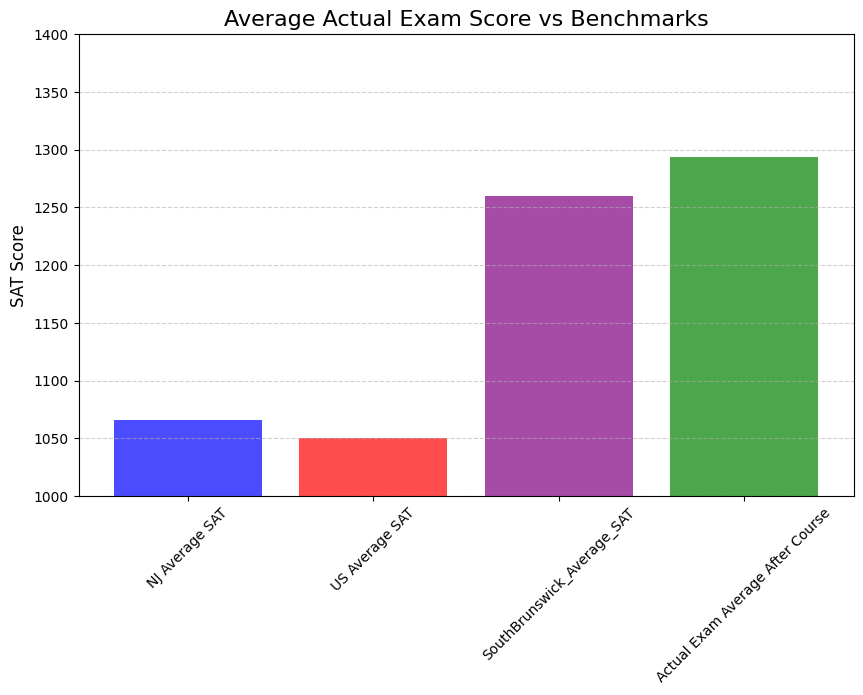

In [40]:
# Calculate average Actual Exam Score
avg_actual_exam = data['Actual Exam'].mean()

# Define benchmarks
benchmarks = {
    'NJ Average SAT': 1066,
    'US Average SAT': 1050,
    'SouthBrunswick_Average_SAT': 1260,
    'Actual Exam Average After Course': avg_actual_exam
}

# Convert benchmarks to lists
labels = list(benchmarks.keys())
values = list(benchmarks.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'purple', 'green'], alpha=0.7)
plt.title("Average Actual Exam Score vs Benchmarks", fontsize=16)
plt.ylabel("SAT Score", fontsize=12)
plt.ylim(1000, 1400)  # Set y-axis range
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()
